## Typical LISA experiment

This notebook shows a typical LISA-use case:

* Connecting to a target
* Configuring an rt-app workload
* Collecting a trace while executing a workload
* Displaying the trace
* Analysing the trace

It can serve as a template for different kind of experiments, - you could only change the workload to execute & the trace events to collect

In [1]:
import logging
from lisa.utils import setup_logging
setup_logging()

2019-02-25 18:37:07,927 INFO    : root         : Using LISA logging configuration:
2019-02-25 18:37:07,928 INFO    : root         :   lisa/remove_testenv/logging.conf


## Target configuration

Target communication is abstracted away under a **Target** class. We're going to create an instance of it and that'll let us run whatever experiment we want on a given target.

Relevant documentation:
* **Target**: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/next/internals.html#lisa.target.Target
* **TargetConf**: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/next/internals.html#lisa.env.TargetConf

In [2]:
from lisa.target import Target, TargetConf

In [3]:
target = Target(
    kind='linux',
    name='myhikey960',
    host='192.168.0.1',
    username='root',
    password='root',
)

2019-02-25 18:37:08,533 INFO    : lisa.target.Target : linux myhikey960 target connection settings:
2019-02-25 18:37:08,534 INFO    : lisa.target.Target :   username : root
2019-02-25 18:37:08,534 INFO    : lisa.target.Target :       port : 22
2019-02-25 18:37:08,535 INFO    : lisa.target.Target :       host : pwrsft-hikey960-1
2019-02-25 18:37:08,535 INFO    : lisa.target.Target :   password : root
2019-02-25 18:37:08,543 INFO    : lisa.target.Target : Devlib modules to load: bl, cgroups, cpufreq, cpuidle, devfreq, fastboot, gem5stats, gpufreq, hotplug, hwmon, mbed-fan, odroidxu3-fan, sched, thermal
2019-02-25 18:37:13,195 WARNING : LinuxTarget  : Module devfreq is not supported by the target
2019-02-25 18:37:13,198 WARNING : LinuxTarget  : Module fastboot is not supported by the target
2019-02-25 18:37:13,200 WARNING : LinuxTarget  : Module gem5stats is not supported by the target
2019-02-25 18:37:13,364 WARNING : LinuxTarget  : Module gpufreq is not supported by the target
2019-02-2

## Setting up an rt-app workload

rt-app is very convenient for scheduler experiments, and the majority of the tests within LISA rely on it. Here we're going to create a somewhat useless workload just to show off the API.

Relevant documentation:
* **rt-app**: https://github.com/scheduler-tools/rt-app
* **rt-app LISA class**: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/next/wlgen.html#lisa.wlgen.rta.RTA
* **Periodic class**: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/next/wlgen.html#lisa.wlgen.rta.Periodic

In [4]:
from lisa.wlgen.rta import RTA, Periodic

In [5]:
rtapp_profile = {}

for cpu in range(target.number_of_cpus):
    for i in range(3):
        rtapp_profile["task_{}_{}".format(cpu, i)] = Periodic(duty_cycle_pct=20)

rt-app needs some calibration information (20% duty cycle isn't the same amount of work on all platforms!). It can be manually specified like so:

In [6]:
def provide_calibration(calibration):
    target.plat_info["rtapp"].add_src("user", {"calib" : calibration})

In [7]:
# Uncomment if you want to use this
# provide_calibration({0: 307, 1: 302, 2: 302, 3: 302, 4: 155, 5: 155, 6: 155, 7: 155})

However, it is automatically collected when first creating an rt-app workload if it is not specified, so you can forego the above step and let the calibration happen on-demand:

In [8]:
wload = RTA.by_profile(target, "experiment_wload", rtapp_profile)

2019-02-25 18:37:28,195 INFO    : lisa.target.Target : Creating result directory: lisa/remove_testenv/results/Target-myhikey960/RTA-experiment_wload-20190225_183728.195401
2019-02-25 18:37:35,137 INFO    : lisa.wlgen.rta.RTA : CPU0 calibration...
2019-02-25 18:37:35,466 INFO    : lisa.wlgen.rta.RTA : Calibration value: CPU0
2019-02-25 18:37:35,467 INFO    : lisa.wlgen.rta.RTA : Default policy: SCHED_OTHER
2019-02-25 18:37:35,470 INFO    : lisa.wlgen.rta.RTA : ------------------------
2019-02-25 18:37:35,472 INFO    : lisa.wlgen.rta.RTA : task [task1], sched: using default policy
2019-02-25 18:37:35,474 INFO    : lisa.wlgen.rta.RTA :  | start delay: 0.000000 [s]
2019-02-25 18:37:35,476 INFO    : lisa.wlgen.rta.RTA :  | loops count: 1
2019-02-25 18:37:35,478 INFO    : lisa.wlgen.rta.RTA :  + phase_000001
2019-02-25 18:37:35,479 INFO    : lisa.wlgen.rta.Phase :  | batch 0.001000 [s]
2019-02-25 18:37:35,690 INFO    : lisa.wlgen.rta.RTA : Execution start: /root/devlib-target/bin/rt-app /roo

## Running the workload

In [9]:
import os
from lisa.trace import FtraceCollector

We need to specify the trace events we want to record. We could list what's available like so:

In [10]:
available_events = target.execute("cat /sys/kernel/debug/tracing/available_events").splitlines()

# That's gonna be a pretty big list, let's focus on the scheduler events
sched_events = [event for event in available_events if event.startswith("sched:")]
print(sched_events)

['sched:uclamp_util_cfs', 'sched:uclamp_util_se', 'sched:sched_overutilized', 'sched:sched_compute_energy', 'sched:sched_util_est_cpu', 'sched:sched_util_est_task', 'sched:sched_load_tg', 'sched:sched_load_se', 'sched:sched_load_cfs_rq', 'sched:sched_wake_idle_without_ipi', 'sched:sched_swap_numa', 'sched:sched_stick_numa', 'sched:sched_move_numa', 'sched:sched_pi_setprio', 'sched:sched_stat_runtime', 'sched:sched_stat_blocked', 'sched:sched_stat_iowait', 'sched:sched_stat_sleep', 'sched:sched_stat_wait', 'sched:sched_process_exec', 'sched:sched_process_fork', 'sched:sched_process_wait', 'sched:sched_wait_task', 'sched:sched_process_exit', 'sched:sched_process_free', 'sched:sched_migrate_task', 'sched:sched_switch', 'sched:sched_wakeup_new', 'sched:sched_wakeup', 'sched:sched_waking', 'sched:sched_kthread_stop_ret', 'sched:sched_kthread_stop']


Let's just collect the base events required to plot task scheduling:

In [11]:
events = [
    "sched_switch",
    "sched_wakeup",
    "sched_wakeup_new"
]

And now we can actually record traces while running our workload:

In [12]:
ftrace_coll = FtraceCollector(target, events=events, buffer_size=10240)

# This is just nifty Python syntactic sugar that starts/stops
# the recording for us. You could just do:
#     ftrace.start()
#     wload.run()
#     ftrace.stop()
#     ftrace.get_trace(trace_path)
trace_path = os.path.join(wload.res_dir, "trace.dat")
with ftrace_coll:
    wload.run()
ftrace_coll.get_trace(trace_path)

2019-02-25 18:38:36,375 INFO    : lisa.wlgen.rta.RTA : Execution start: /root/devlib-target/bin/rt-app /root/devlib-target/experiment_wload.json 2>&1
2019-02-25 18:38:37,587 INFO    : lisa.wlgen.rta.RTA : Execution complete


## Loading up the trace

We have a Trace class that lets us easily access trace events. It can also do some post-processing to provide different kinds of analysis.

In [13]:
from lisa.trace import Trace

We also save some platform information (number of CPUs, available frequencies, kernel version...) that comes in handy for doing some analysis:

In [15]:
print(target.plat_info)

|- abi from target (str): arm64
|- cpu-capacities from target (dict): {0: 462, 1: 462, 2: 462, 3: 462, 4: 1024, 5: 1024, 6: 1024, 7: 1024}
|- cpus-count from target (int): 8
|- freq-domains from target (list): [[0, 1, 2, 3], [4, 5, 6, 7]]
|- freqs from target (dict): {0: [533000, 999000, 1402000, 1709000, 1844000], 1: [533000, 999000, 1402000, 1709000, 1844000], 2: [533000, 999000, 1402000, 1709000, 1844000], 3: [533000, 999000, 1402000, 1709000, 1844000], 4: [903000, 1421000, 1805000, 2112000, 2362000], 5: [903000, 1421000, 1805000, 2112000, 2362000], 6: [903000, 1421000, 1805000, 2112000, 2362000], 7: [903000, 1421000, 1805000, 2112000, 2362000]}
+- kernel:
    |- config from target (TypedKernelConfig): <kernel config>
    |- version from target (KernelVersion): 5.0.0-rc6 27 SMP PREEMPT Tue Feb 19 17:28:19 GMT 2019
|- name from target-conf (str): myhikey960
|- nrg-model from target (EnergyModel): <lisa.energy_model.EnergyModel object at 0x7f80637fa828>
|- os from target (str): linux


You can pass the platform info directly from the **Target**:

In [16]:
trace_path = os.path.join(wload.res_dir, 'trace.dat')
trace = Trace(trace_path, target.plat_info, events=events)

... But it's a good idea to save it on the disk so that you can re-run whatever analysis code you want several months down the line after the platform was lost in a tragic fire.

It's why we save this information somewhere instead of polling the target when we want to use them - we can run analysis code offline.

Here we show how to save to/restore this platform information from the disk.

In [18]:
plat_info_path = os.path.join(wload.res_dir, "platinfo.yaml")
target.plat_info.to_yaml_map(plat_info_path)

In [19]:
from lisa.platforms.platinfo import PlatformInfo

In [20]:
plat_info = PlatformInfo.from_yaml_map(plat_info_path)
trace = Trace(trace_path, plat_info, events=events)

## Looking at the trace

One of the first things you can do with that trace is display it in the Notebook. The inline plotter is not as feature-complete as Kernelshark, but it's useful as a quick way to plot the trace.

In [21]:
from trappy.plotter import plot_trace

In [22]:
plot_trace(trace.ftrace)

Kernelshark is still an option:

In [23]:
!kernelshark {trace_path}

trace-cmd: No such file or directory
  [xhci-hcd:xhci_urb_giveback] bad op token {
  [xhci-hcd:xhci_urb_enqueue] bad op token {
  [xhci-hcd:xhci_urb_dequeue] bad op token {
  [xhci-hcd:xhci_setup_device_slot] function xhci_decode_slot_context not defined
  [xhci-hcd:xhci_ring_free] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_ring_expansion] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_ring_alloc] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_queue_trb] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_inc_enq] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_inc_deq] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_hub_status_data] function xhci_decode_portsc not defined
  [xhci-hcd:xhci_handle_transfer] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_handle_port_status] function xhci_decode_portsc not defined
  [xhci-hcd:xhci_handle_event] function xhci_ring_type_string not defined
  [xhci-hcd:xhc

## Analysing the trace

Relevant documentation: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/next/analysis.html

### Reading trace events

In [24]:
df = trace.df_events("sched_switch")
df

,__comm,__cpu,__line,__pid,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state
Time,,,,,,,,,,,
0.000081,<...>,0,1,7064,swapper/0,0,120,trace-cmd,7064,120,32
0.000345,<idle>,3,2,0,sh,6695,120,swapper/3,0,120,0
0.001656,<idle>,0,4,0,kworker/u16:1,6721,120,swapper/0,0,120,0
0.001758,sh,3,5,6695,swapper/3,0,120,sh,6695,120,1
0.001856,kworker/u16:1,0,7,6721,swapper/0,0,120,kworker/u16:1,6721,120,128
0.002165,<idle>,2,8,0,sshd,6692,120,swapper/2,0,120,0
0.003026,sshd,2,9,6692,swapper/2,0,120,sshd,6692,120,1
0.004100,<idle>,3,11,0,rcu_preempt,10,120,swapper/3,0,120,0
0.004267,rcu_preempt,3,12,10,swapper/3,0,120,rcu_preempt,10,120,128


The standard DataFrame operations are available, so you can filter/slice it however you wish:

In [25]:
df[df.next_comm == "task_4_1"][1.5:2]

,__comm,__cpu,__line,__pid,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state
Time,,,,,,,,,,,
1.528502,<...>,5,2026,7089,task_4_1,7099,120,task_1_0,7089,120,0
1.551527,<...>,5,2046,7107,task_4_1,7099,120,task_7_0,7107,120,0
1.628501,<...>,7,2125,7095,task_4_1,7099,120,task_3_0,7095,120,0
1.663758,<...>,7,2151,7104,task_4_1,7099,120,task_6_0,7104,120,1
1.728769,<idle>,5,2456,0,task_4_1,7099,120,swapper/5,0,120,0
1.728892,kworker/u16:1,5,2461,6721,task_4_1,7099,120,kworker/u16:1,6721,120,128
1.728944,kworker/u16:1,5,2464,6721,task_4_1,7099,120,kworker/u16:1,6721,120,128


### Using the trace analysis

#### Example dataframes

In [26]:
trace.analysis.tasks.df_rt_tasks()

,prio,comm
pid,,
7027,-1,sugov:0
7037,-1,sugov:4
11,0,migration/0
14,0,migration/1
19,0,migration/2
24,0,migration/3
29,0,migration/4
34,0,migration/5
39,0,migration/6


In [27]:
df = trace.analysis.tasks.df_task_states("task_4_1", stringify=True)
df

,target_cpu,cpu,curr_state,next_state,delta
Time,,,,,
0.701949,5,5,W,A,0.000022
0.701971,-1,6,A,D,0.000053
0.702024,-1,6,D,W,0.000226
0.702250,6,5,W,A,0.000231
0.702481,-1,6,A,D,0.000020
0.702501,-1,6,D,W,0.000526
0.703027,6,6,W,A,0.000021
0.703048,-1,6,A,S,0.000019
0.703067,-1,6,S,W,0.008632


In [28]:
from lisa.analysis.tasks import TaskState

In [29]:
df[df.curr_state == TaskState.TASK_ACTIVE.char][1:1.2]

,target_cpu,cpu,curr_state,next_state,delta
Time,,,,,
1.051543,-1,2,A,R,0.011999
1.079541,-1,2,A,R,0.020267
1.122482,-1,5,A,R,0.013419
1.143925,-1,6,A,S,0.014116


#### Example plots

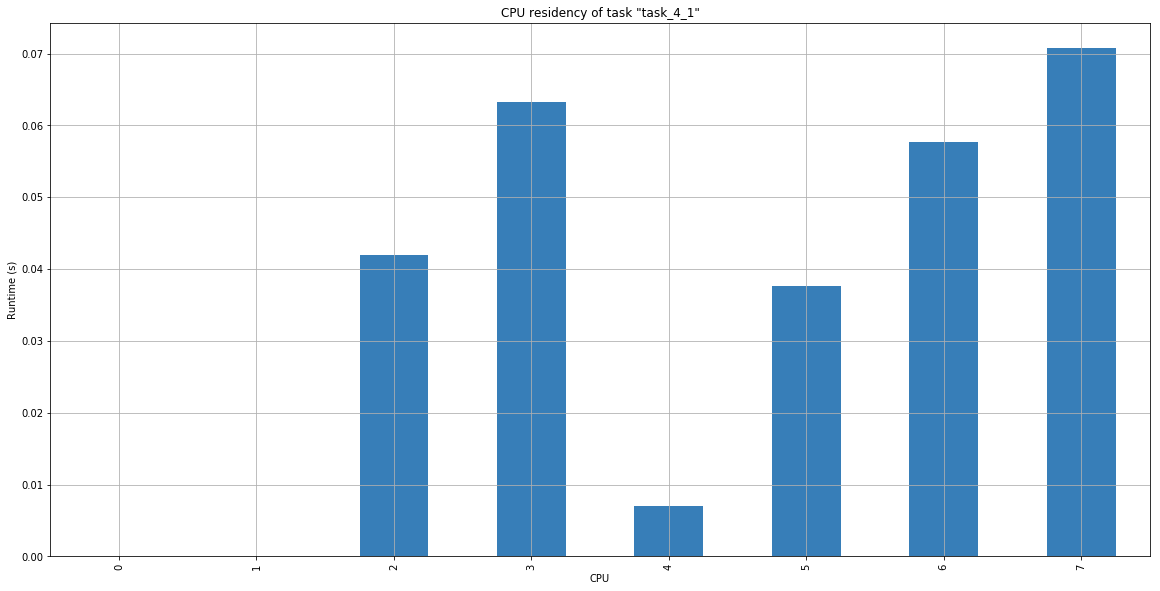

In [30]:
trace.analysis.tasks.plot_task_total_residency("task_4_1")

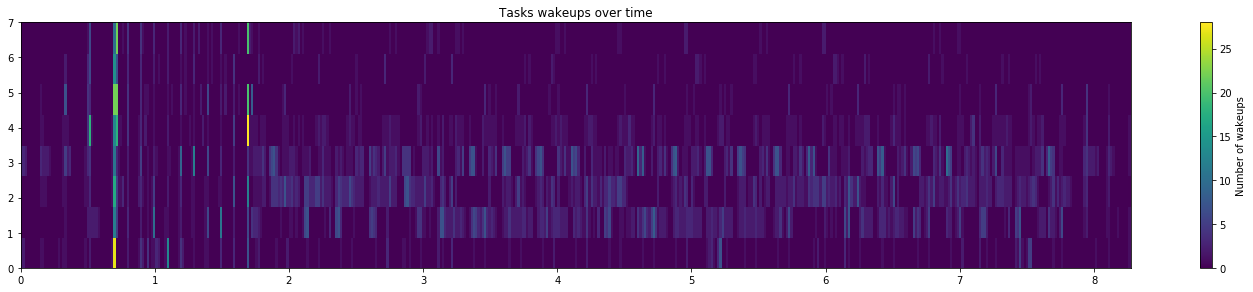

In [31]:
trace.analysis.tasks.plot_tasks_wakeups_heatmap(xbins=500)

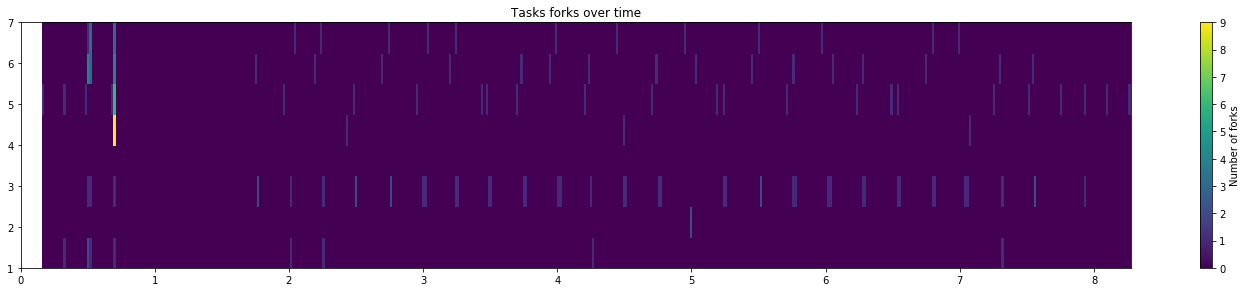

In [32]:
trace.analysis.tasks.plot_tasks_forks_heatmap(xbins=500)